In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

In [18]:
import numpy as np
import pandas as pd

In [31]:
import datetime #as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, create_engine, inspect

In [21]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [26]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

('2010-01-01',)
('2010-01-02',)
('2010-01-03',)
('2010-01-04',)
('2010-01-06',)
            precipitation
date                     
2016-08-23           0.00
2016-08-24           0.08
2016-08-25           0.08
2016-08-26           0.00
2016-08-27           0.00
2016-08-28           0.01
2016-08-29           0.00
2016-08-30           0.00
2016-08-31           0.13
2016-09-01           0.00
2016-09-02           0.00
2016-09-03           0.00
2016-09-04           0.03
2016-09-05            NaN
2016-09-06            NaN
2016-09-07           0.05
2016-09-08           0.00
2016-09-09           0.03
2016-09-10           0.00
2016-09-11           0.05
2016-09-12           0.00
2016-09-13           0.02
2016-09-14           1.32
2016-09-15           0.42
2016-09-16           0.06
2016-09-17           0.05
2016-09-18           0.00
2016-09-19           0.00
2016-09-20           0.00
2016-09-21           0.00
...                   ...
2017-07-24           0.84
2017-07-25           0.30
2017-07-26

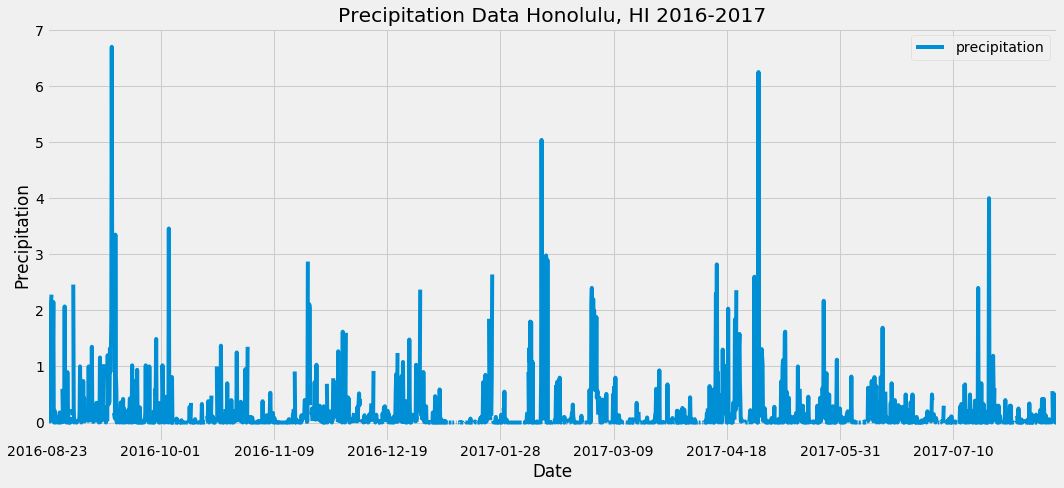

In [60]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
start_date = datetime.date(2019, 1, 4)
end_date = datetime.date(2019, 1, 18)

# Calculate the date 1 year ago from the last data point in the database
sample_dates = session.query(Measurement.date).limit(5).all()
for result in sample_dates:
    print(result)
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precip_data, columns = ['date', 'precipitation'])
precipitation_df.set_index('date', inplace = True)
print(precipitation_df)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by = 'date')
print(precipitation_df)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (15, 7))
precipitation_df.plot(ax = ax, x_compat = True)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation')
ax.set_title("Precipitation Data Honolulu, HI 2016-2017")
plt.savefig("Honolulu_HI_Plots/precipitation_data.png")
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [51]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).distinct().count()
station_count

9

In [52]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station_count_desc = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in active_station_count_desc:
    print(f"Station: {result[0]}\tCount: {result[1]}")



Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [55]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = 'USC00519281'
active_station_temp_data = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"Lowest Temperature in {most_active_station} : {active_station_temp_data[0][0]} degrees Fahrenheit")
print(f"Highest Temperature in {most_active_station}: {active_station_temp_data[0][1]} degrees Fahrenheit")
print(f"Average Temperature in {most_active_station}: {round(active_station_temp_data[0][2], 2)} degrees Fahrenheit")

Lowest Temperature in USC00519281 : 54.0 degrees Fahrenheit
Highest Temperature in USC00519281: 85.0 degrees Fahrenheit
Average Temperature in USC00519281: 71.66 degrees Fahrenheit


           date  temperature
0    2016-08-23         77.0
1    2016-08-24         77.0
2    2016-08-25         80.0
3    2016-08-26         80.0
4    2016-08-27         75.0
5    2016-08-28         73.0
6    2016-08-29         78.0
7    2016-08-30         77.0
8    2016-08-31         78.0
9    2016-09-01         80.0
10   2016-09-02         80.0
11   2016-09-03         78.0
12   2016-09-04         78.0
13   2016-09-05         78.0
14   2016-09-06         73.0
15   2016-09-07         74.0
16   2016-09-08         80.0
17   2016-09-09         79.0
18   2016-09-10         77.0
19   2016-09-11         80.0
20   2016-09-12         76.0
21   2016-09-13         79.0
22   2016-09-14         75.0
23   2016-09-15         79.0
24   2016-09-16         78.0
25   2016-09-17         79.0
26   2016-09-18         78.0
27   2016-09-19         78.0
28   2016-09-20         76.0
29   2016-09-21         74.0
..          ...          ...
322  2017-07-11         72.0
323  2017-07-12         74.0
324  2017-07-1

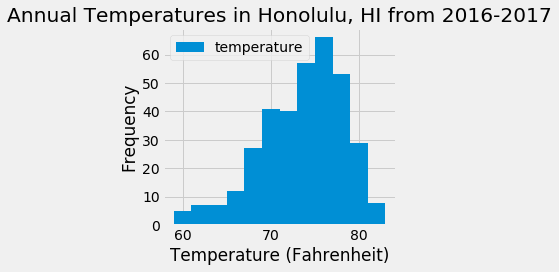

In [61]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
annual_temp_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

annual_temp_df = pd.DataFrame(annual_temp_data, columns = ['date', 'temperature'])
print(annual_temp_df)

annual_temp_df.set_index('date', inplace = True)

#plot histogram
fig, ax = plt.subplots()
annual_temp_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Annual Temperatures in Honolulu, HI from 2016-2017")

#save figure
plt.savefig("Honolulu_HI_Plots/temp_histogram.png")

#plot
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [43]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [57]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp_data = calc_temps('2017-01-04', '2017-01-18')

print(f"Lowest Temperature: {trip_temp_data[0][0]} degrees Fahrenheit")
print(f"Average Temperature: {round(trip_temp_data[0][1], 2)} degrees Fahrenheit")
print(f"Highest Temperature: {trip_temp_data[0][2]} degrees Fahrenheit")

Lowest Temperature: 60.0 degrees Fahrenheit
Average Temperature: 69.26 degrees Fahrenheit
Highest Temperature: 81.0 degrees Fahrenheit


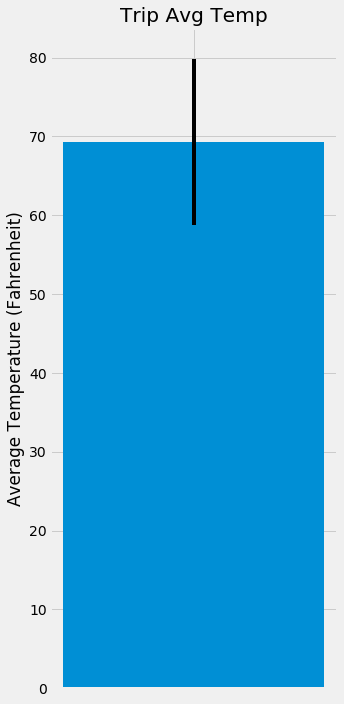

In [62]:
# Plot the results from your previous query as a bar chart. 


# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
pk_to_pk = trip_temps[0][2] - trip_temps[0][0]
avg_temp = trip_temps[0][1]
fig, ax = plt.subplots(figsize = (5, 10))
ax.bar(1, avg_temp, yerr = pk_to_pk/2, width = 0.4)

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Average Temperature (Fahrenheit)')

#save fig
plt.savefig("Honolulu_HI_Plots/temp_bar_chart.png")

#show figure
plt.tight_layout()
plt.show()

In [59]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#get average rainfall for each weather station for the last year
annual_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.avg(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).group_by(Station.station).\
    order_by(func.avg(Measurement.prcp).desc()).all()

#load into a dataframe
annual_rainfall_df = pd.DataFrame(annual_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

annual_rainfall_df.head()


,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.450640
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.125434
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.121051


## Optional Challenge Assignment

In [48]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


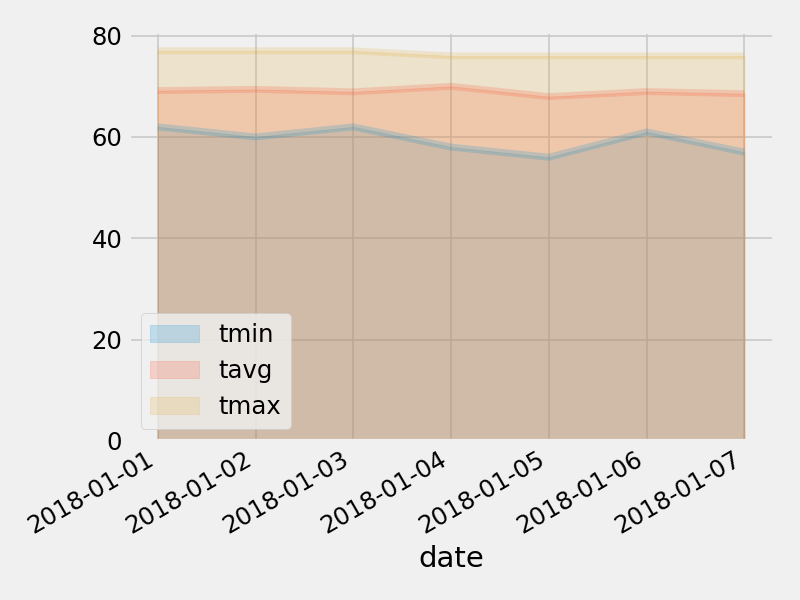

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
